In [4]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 457 (delta 115), reused 98 (delta 82), pack-reused 250
Receiving objects: 100% (457/457), 73.76 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=85777bbc96adf0bdaafb01f3d007635cbcd67201cc55e5a4c6dc06136b9a7c3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b8kzd67/wheels/55/59/29/0fb1c6356521

In [5]:
from dul_2021.utils.hw7_utils import *

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


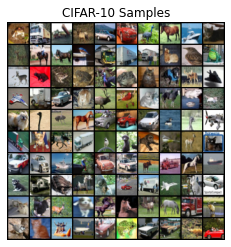

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4)
        output = output.reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, block_size=2, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()

        self.main = nn.Sequential(DepthToSpace(block_size), nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding))

    def forward(self, x):
        return self.main(torch.cat([x, x, x, x], dim=1))


class DownSample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, block_size=2, kernel_size=(3, 3), stride=1, padding=1, bias=False):
        super().__init__()

        self.s2d = SpaceToDepth(block_size)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, bias=bias)

    def forward(self, x):
        x = self.conv(sum(self.s2d(x).chunk(4, dim=1)) / 4.0)
        return x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters=256, kernel_size=(3, 3)):
        super().__init__()
        self.main = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
        )
        self.residual = UpSample_Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=1)
        self.shortcut = UpSample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        x = self.residual(self.main(x)) + self.shortcut(x)
        return x


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters=256, kernel_size=(3, 3)):
        super().__init__()
        self.main = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
        )
        self.residual = DownSample_Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=1)
        self.shortcut = DownSample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        z = self.main(x)
        return self.residual(z) + self.shortcut(x)


class Generator(nn.Module):
    def __init__(self, n_filters=256, z_dim=128):
        super().__init__()
        self.n_filters = n_filters
        self.z_dim = z_dim
        self.fc = nn.Linear(z_dim, 4 * 4 * n_filters)
        self.main = nn.Sequential(
            ResnetBlockUp(n_filters, n_filters),
            ResnetBlockUp(n_filters, n_filters),
            ResnetBlockUp(n_filters, n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh(),
        )
        self.bdist = Normal(torch.tensor(0.0, dtype=torch.float32), torch.tensor(1.0, dtype=torch.float32))

    def forward(self, z):
        out = self.fc(z).reshape(-1, self.n_filters, 4, 4)
        return self.main(out)

    def sample(self, n_samples=100):
        z = self.bdist.sample([n_samples, self.z_dim]).to(device)
        return self(z)


class Critic(nn.Module):
    def __init__(self, n_filters=256):
        super().__init__()
        self.main = nn.Sequential(
            ResnetBlockDown(3, n_filters),
            ResnetBlockDown(n_filters, n_filters),
            ResnetBlockDown(n_filters, n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(4, 4), padding=0),
        )
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.main(x)
        x = x.squeeze()
        x = self.fc(x)
        return x


class SN_GAN(nn.Module):
    def __init__(self, n_filters=128, lr=2e-4, n_critic=5, lam=10.0):
        super().__init__()
        self.n_critic = n_critic
        self.lam = lam

        self.generator = Generator(n_filters)
        self.critic = Critic(n_filters)

        self.g_optim = Adam(self.generator.parameters(), lr=lr, betas=(0, 0.9))
        self.c_optim = Adam(self.critic.parameters(), lr=lr, betas=(0, 0.9))

    def critic_loss(self, real, fake):
        score_real = self.critic(real)
        score_fake = self.critic(fake)
        return -score_real.mean() + score_fake.mean() + self.lam * self.__gradient_penalty(real, fake)

    def __gradient_penalty(self, real, fake):
        bs = real.shape[0]
        eps = torch.rand(bs, 1, 1, 1).to(device).expand_as(real)
        interps = eps * real + (1 - eps) * fake
        scores = self.critic(interps)
        grads = torch.autograd.grad(scores, interps, torch.ones_like(scores, device=device), create_graph=True)[
            0].reshape(bs, -1)
        return torch.mean((torch.norm(grads, dim=1) - 1) ** 2)

    def fit(self, train_data, batch_size, n_iter):
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
        losses = []

        epochs = n_iter // len(trainloader)

        g_scheduler = LambdaLR(self.g_optim, lambda epoch: (epochs - epoch) / epochs, last_epoch=-1)
        c_scheduler = LambdaLR(self.c_optim, lambda epoch: (epochs - epoch) / epochs, last_epoch=-1)

        for epoch in range(epochs):
            for i, batch_real in enumerate(trainloader):

                batch_real = batch_real.to(device)
                batch_fake = self.generator.sample(batch_real.shape[0])

                critic_losses = self.critic_loss(batch_real, batch_fake)

                self.c_optim.zero_grad()
                critic_losses.backward()
                self.c_optim.step()

                losses.append(critic_losses.detach().cpu().numpy())

                if i * epoch % self.n_critic == 0:
                    g_loss = -self.critic(self.generator.sample(batch_real.shape[0])).mean()

                    self.g_optim.zero_grad()
                    g_loss.backward()
                    self.g_optim.step()

            g_scheduler.step()
            c_scheduler.step()

        return np.array(losses)

    def sample(self, n):
        with torch.no_grad():
            return self.generator.sample(n)


In [ ]:
def q1(train_data, n_iter=1000,  batch_size=64, lr=2e-4):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    train_data = torch.FloatTensor(train_data)
    train_data = (train_data  - 0.5) * 2 
    
    model = SN_GAN(lr=lr).to(device)
    losses = model.fit(train_data,batch_size, n_iter)
    
    model.eval()
    samples = (model.sample(1000) + 1) * 0.5  # convert to [0, 1] as G has tanh
    samples = samples.permute(0, 2, 3, 1).cpu().numpy()
    return losses, samples

## Results

Files already downloaded and verified
..........Inception score: 2.9652956


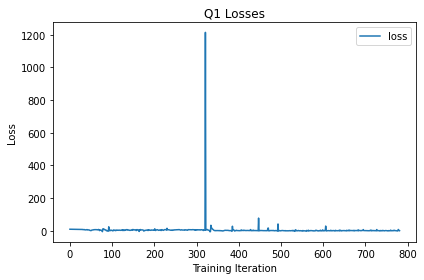

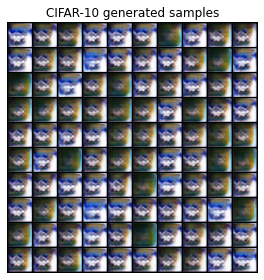

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


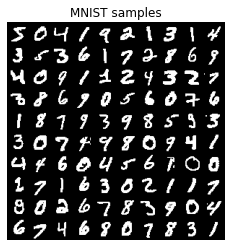

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
import torch
import torch.nn as nn

from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class E(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(E, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        output = self.model(x.reshape(batch_size, -1))
        return output


class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

        self.distribution = torch.distributions.Normal(
            torch.tensor(0, dtype=torch.float32).to(device),
            torch.tensor(1, dtype=torch.float32).to(device))

    def forward(self, z):
        batch_size = z.shape[0]
        output = self.model(z).reshape(batch_size, 1, 28, 28)
        return output

    def sample(self, n_samples):
        z = self.distribution.sample((n_samples, 50))
        return self(z), z


class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(834, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        batch_size = x.shape[0]
        flatten_x = x.reshape(batch_size, -1)
        output = self.model(torch.cat([z, x.reshape(batch_size, -1)], dim=1))
        return output


class BiGAN(nn.Module):
    def __init__(self):
        super(BiGAN, self).__init__()

        self.generator = G().to(device)
        self.discriminator = D().to(device)
        self.encoder = E(28 * 28, 50).to(device)
        self.classifier = nn.Linear(50, 10).to(device)

        self.epochs = 70
        self.batch_size = 256

    def loss(self, real_data):
        batch_size = real_data.shape[0]

        z_real = self.encoder(real_data)
        real_loss = self.discriminator(z_real, real_data)

        fake_data, z_fake = self.generator.sample(batch_size)
        fake_loss = self.discriminator(z_fake, fake_data)

        loss = torch.log(real_loss) + torch.log(1 - fake_loss)

        return -loss.mean()

    def evaluate(self, dataloader):
        total_loss = []
        for batch, label in dataloader:
            batch = batch.to(device)
            label = label.to(device)

            z = self.encoder(batch)

            loss = F.cross_entropy(self.classifier(z), label)
            total_loss.append(loss.item())
        return np.mean(total_loss)

    def fit_classifier(self, train_loader, eval_loader):
        classifier_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

        train_losses = []
        val_losses = []

        self.encoder.eval()
        val_losses.append(self.evaluate(eval_loader))

        for epoch in range(self.epochs):
            for batch, label in train_loader:
                batch = batch.to(device)
                label = label.to(device)

                with torch.no_grad():
                    z = self.encoder(batch)

                loss = F.cross_entropy(self.classifier(z), label)

                classifier_optimizer.zero_grad()
                loss.backward()
                classifier_optimizer.step()

                train_losses.append(loss.item())
            val_losses.append(self.evaluate(eval_loader))

        self.encoder.train()

        return train_losses, val_losses

    def fit(self, train_loader, val_loader):
        generator_params = list(self.encoder.parameters()) + list(self.generator.parameters())
        generator_optimizer = torch.optim.Adam(generator_params, lr=2e-4, betas=(0.5, 0.9))
        generator_scheduler = torch.optim.lr_scheduler.LambdaLR(generator_optimizer,
                                                                lambda epoch: (self.epochs - epoch) / self.epochs,
                                                                last_epoch=-1)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0, 0.9))
        discriminator_scheduler = torch.optim.lr_scheduler.LambdaLR(discriminator_optimizer,
                                                                    lambda epoch: (self.epochs - epoch) / self.epochs,
                                                                    last_epoch=-1)
        eval_losses = []
        train_losses = []

        eval_losses.append(self.evaluate(val_loader))
        for epoch in range(self.epochs):
            for batch, label in val_loader:
                batch = batch.to(device)
                disc_loss = self.loss(batch)
                discriminator_optimizer.zero_grad()
                disc_loss.backward()
                discriminator_optimizer.step()

                gen_loss = -self.loss(batch)
                generator_optimizer.zero_grad()
                gen_loss.backward()
                generator_optimizer.step()

            train_losses.append(self.evaluate(val_loader))
            generator_scheduler.step()
            discriminator_scheduler.step()
        return np.array(train_losses), np.array(eval_losses)

    def sample(self, n):
        noise = torch.rand(n, 50).to(device) - 0.5
        z = 2 * noise

        self.generator.eval()
        samples = 0.5 * self.generator(z) + 0.5
        self.generator.train()
        return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)

    def recon(self, batch):
        batch = batch.to(device)
        self.encoder.eval()
        self.generator.eval()
        z = self.encoder(batch)
        z_hat = self.generator(z)
        self.encoder.train()
        self.generator.train()
        data = 0.5 * torch.cat([batch, z_hat]) + 0.5
        return data.detach().cpu().numpy().transpose(0, 2, 3, 1)


In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    train_dataset = Dataset(train_data)
    train_loader = train_dataset.get_data_loader(256)

    test_dataset = Dataset(test_data)
    test_loader = test_dataset.get_data_loader(256)

    model = BiGAN()
    _, bi_gan_test_loss = model.fit_classifier(train_loader, test_loader)
    train_loss, _ = model.fit(train_loader, test_loader)
    samples = model.sample(100)
    recon = model.recon(
        torch.stack([test_data[i][0] for i in p.random.choice(len(test_data), 20, replace=False)]))
    model.classifier.reset_parameters()
    _, class_test_loss = model.fit_classifier(train_loader, test_loader)
    return train_loss, samples, recon, class_test_loss, bi_gan_test_loss

## Results

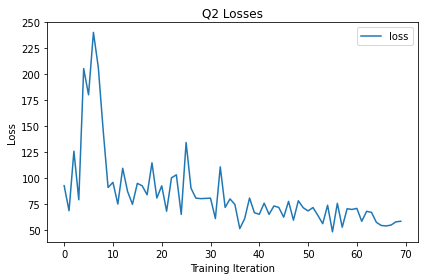

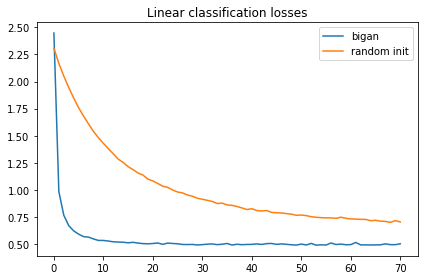

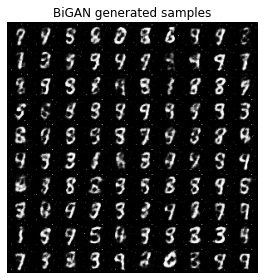

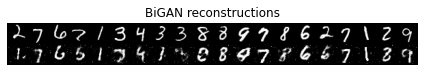

BiGAN final linear classification loss: 0.5061073020100594
Random encoder linear classification loss: 0.7070132225751877


In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



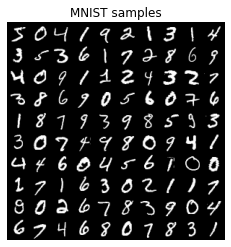

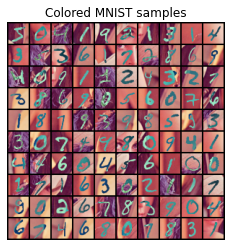

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def generate_sample(G, G_other, data):
    random_idx = np.random.randint(low=0, high=data.shape[0] - 1, size=20)
    chosen = data[random_idx]

    tensor_data = torch.tensor(chosen, device=device).float()

    with torch.no_grad():
        fake = G(tensor_data)
        rec = G_other(fake)

    fake = fake.permute(0, 2, 3, 1)
    fake = fake.cpu().numpy()

    rec = rec.permute(0, 2, 3, 1)
    rec = rec.cpu().numpy()

    real = tensor_data.permute(0, 2, 3, 1)
    real = real.cpu().numpy()

    return real, fake, rec


class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size, padding=1, stride=1):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(in_dim, n_filters, kernel_size, stride, padding),
                                   nn.BatchNorm2d(n_filters),
                                   nn.ReLU())

    def forward(self, x):
        return self.model(x)


class ResBlock(nn.Module):
    def __init__(self, in_dim=64, n_filters=64, kernel_size=(3, 3)):
        super().__init__()
        self.model = nn.Sequential(Conv_BN_ReLU(in_dim, n_filters, kernel_size),
                                   nn.Conv2d(n_filters, n_filters, kernel_size, padding=1),
                                   nn.BatchNorm2d(n_filters))

    def forward(self, x):
        output = self.model(x) + x
        return output


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(Conv_BN_ReLU(in_channels, 32, kernel_size=(3, 3), stride=2),
                                   Conv_BN_ReLU(32, 64, kernel_size=(3, 3), stride=2),
                                   ResBlock(),
                                   ResBlock(),
                                   ResBlock(),
                                   nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(32, out_channels, kernel_size=(3, 3), padding=1, stride=1)
                                   )

    def forward(self, x):
        output = self.model(x)
        output = torch.clip(output, -1, 1)
        output = torch.abs(output)
        return output


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 128, kernel_size=(3, 3), stride=2, padding=1),
                                   nn.Conv2d(128, 128, kernel_size=(3, 3), stride=2, padding=1),
                                   nn.Conv2d(128, 128, kernel_size=(3, 3), stride=2, padding=1),
                                   nn.Conv2d(128, 128, kernel_size=(3, 3), stride=2, padding=1),
                                   nn.Conv2d(128, 128, kernel_size=(3, 3), stride=2, padding=1),
                                   nn.Flatten(),
                                   nn.Linear(128, 1)
                                   )

    def forward(self, x):
        output = self.model(x)
        return output


class CycleGAN():
    def __init__(self, x_channels, y_channels, device, batch_size=256):
        self.Dx = Discriminator(x_channels).to(device)
        self.Dx_optim = optim.Adam(self.Dx.parameters(), lr=2e-4)

        self.Dy = Discriminator(y_channels).to(device)
        self.Dy_optim = optim.Adam(self.Dy.parameters(), lr=2e-4)

        self.Gx = Generator(x_channels, y_channels).to(device)
        self.Gx_optim = optim.Adam(self.Gx.parameters(), lr=2e-4)

        self.Gy = Generator(y_channels, x_channels).to(device)
        self.Gy_optim = optim.Adam(self.Gy.parameters(), lr=2e-4)

        self.ones = torch.ones((batch_size, 1), device=device)
        self.mse = nn.MSELoss()
        self.L1 = nn.L1Loss()
        self.lamb = 5

    def dis_loss(self, D, G, data, other_data):
        with torch.no_grad():
            fake_data = G(other_data)

        d_loss = self.mse(D(data), self.ones[:data.shape[0]])
        d_loss += (D(fake_data) ** 2).mean()
        return d_loss

    def full_gen_loss(self, D, G, G_other, data):
        fake_data = G_other(data)
        loss = self.mse(D(fake_data), self.ones[:data.shape[0]]) + self.L1(G(fake_data), data) * self.lamb
        return loss

    def fit(self, a_data, b_data, num_epochs=5):
        for epoch in range(num_epochs):
            for counter, (grey_im, color_im) in enumerate(zip(a_data, b_data)):
                grey_im = grey_im.to(device)
                color_im = color_im.to(device)

                loss_x = self.dis_loss(self.Dx, self.Gy, grey_im, color_im)
                loss_y = self.dis_loss(self.Dy, self.Gx, color_im, grey_im)

                self.Dx_optim.zero_grad()
                self.Dy_optim.zero_grad()

                loss_x.backward()
                loss_y.backward()

                self.Dx_optim.step()
                self.Dy_optim.step()
                if (counter + 1) % 5 == 0:
                    g_loss = self.full_gen_loss(self.Dx, self.Gx, self.Gy, color_im)
                    g_loss += self.full_gen_loss(self.Dy, self.Gy, self.Gx, grey_im)

                    self.Gx_optim.zero_grad()
                    self.Gy_optim.zero_grad()

                    g_loss.backward()

                    self.Gx_optim.step()
                    self.Gy_optim.step()

In [10]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """

    mnist_data = DataLoader(torch.tensor(mnist_data, device=device), batch_size=100)
    cmnist_data = DataLoader(torch.tensor(cmnist_data, device=device).float(), batch_size=100)
    model = CycleGAN(1, 3, device, 100)
    model.fit(mnist_data, cmnist_data)

    real_g, fake_c, rec_g = generate_sample(model.Gx, model.Gy, mnist_data)
    real_c, fake_g, rec_c = generate_sample(model.Gy, model.Gx, cmnist_data)

    return real_g, fake_c, rec_g, real_c, fake_g, rec_c

## Results

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



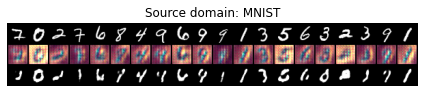

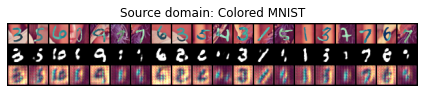

In [8]:
b5_save_results(b5)